In [1]:
import pandas as pd
%pylab inline
import pickle

Populating the interactive namespace from numpy and matplotlib


In [2]:
abstracts_df = pd.read_pickle('abstracts1.pkl')
abstracts_df.describe()

,Issue,Journal,Pages,Volume,abstract,category,date,doi,title
count,27412,27412,27412,27412,27412,27412,27412,27412,27412
unique,32,1,18241,127,27412,702,734,27412,27233
top,Issue 1,Journal of Animal Science,Pages 1–8,Volume 94,The primary corpus luteum was marked with ink ...,Ruminant Nutrition,2016-09-01 00:00:00,https://doi.org/10.2527/jas1974.393606x,Discussion
freq,4709,27412,23,1194,1,4008,291,1,31
first,NaN,NaN,NaN,NaN,NaN,NaN,1910-01-01 00:00:00,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,2018-07-28 00:00:00,NaN,NaN


In [3]:
abstracts_df.index = range(len(abstracts_df.index))

In [4]:
abstracts_df.head()

,Issue,Journal,Pages,Volume,abstract,category,date,doi,title
0,Issue 1,Journal of Animal Science,Pages 391,Volume 1940,"Edward Browning Meigs died November 5, 1940. B...",Business Meeting,1940-12-01,https://doi.org/10.2527/jas1940.19401391x,Edward Browning Meigs
1,Issue 1,Journal of Animal Science,Pages 175–180,Volume 1939,Approximately 38 percent of the total land are...,Sheep and Wool,1939-12-01,https://doi.org/10.2527/jas1939.19391175x,The Production and Marketing of Feeder Lambs i...
2,Issue 1,Journal of Animal Science,Pages 412,Volume 1933,"Harry Hayward, N. W. Ayer &amp; Son, 308 Chest...",Article,1933-01-01,https://doi.org/10.2527/jas1933.19331412x,In Memoriam
3,Issue 8,Journal of Animal Science,Pages 3503–3512,Volume 96,Data from a recent survey suggest that the maj...,Symposia,2018-07-28,https://doi.org/10.1093/jas/sky026,Forages and pastures symposium: cover crops in...
4,Issue 1,Journal of Animal Science,Pages 231–232,Volume 1928,"Saturday Afternoon, November 26, 1927The twent...",Committee and Business Reports,1928-01-01,https://doi.org/10.2527/jas1928.19281231x,Minutes of the Twentieth Annual Business Meeting


In [5]:
abstracts = abstracts_df['abstract']
abstracts.index = range(len(abstracts.index))

In [6]:
abstracts_df.to_pickle('jas_df.pkl')
abstracts.to_pickle('jas_abstracts.pkl')

# KEY FUNCTIONS

In [7]:
#  more stop words
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import string
from nltk.tag import pos_tag

def noun_tokenizer(text):

    # remove punctuation
    punct = string.punctuation + '±−≤°≥“”'
    remove_punct = str.maketrans('', '', punct)
    text = text.translate(remove_punct)

    # remove digits and convert to lower case
    remove_digits = str.maketrans('', '', string.digits)
    text = text.lower().translate(remove_digits)

    # tokenize
    tokens = word_tokenize(text)

    is_noun = lambda pos: (pos == 'NN') | (pos == 'NNS') #only nouns - no proper nouns
    nouns = [word for (word, pos) in pos_tag(tokens) if is_noun(pos)]
    # remove stop words
    stop_words = stopwords.words('english')
    JAS_words = ['use', 'model', 'anim', 'method', 'result', 'kg', 'vs', 'treatment', 'mgkg', 'per', 'h', 'x']
    more_words = ['et', 'al', 'mg', 'cm', 'animals', 'animal', 'mm', 'experiment','treatments','containing', 'studies', 'added', 'sources', 'total', 'science', 'research', 'field', 'degree','report', 'greater', 'increased', 'decreased', 'less', 'use', 'production', 'agriculture']
    stop_words = stop_words + JAS_words + more_words
    tokens_stop = [y for y in tokens if y not in stop_words]

    # stem
    #stemmer = SnowballStemmer('english')
    #tokens_stem = [stemmer.stem(y) for y in tokens_stop] 

    return tokens_stop

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF

def noun_tfidf_and_nmf(corpus, max_df=0.9):
    '''Input: List of documents
       Output: tuple(vocab of words, nmf model, Nxk matrix of weights, vectorizer)
       
       Requires customer_tokenizer defined'''
    # countvectorizing and training
    tfidf = TfidfVectorizer(tokenizer=noun_tokenizer, max_df=max_df, min_df=2)
    X_train_tfidf = tfidf.fit_transform(corpus)
    
    # flip key:index to allow for lookup using index
    vocab = dict((v, k) for k, v in tfidf.vocabulary_.items())
    nmf = NMF(n_components=100)
    nmf_vecs = nmf.fit_transform(X_train_tfidf)
    return vocab, nmf, nmf_vecs, tfidf

In [9]:
#fit data and find topics
%time abstracts_vocab, abstracts_nmf, abstracts_vecs, jas_tfidf = noun_tfidf_and_nmf(abstracts, max_df=0.8)
# argsort gives you the indices of the sorted order in ascending order, taking negative  makes it desc
nmf_topic_words = [topic[:15] for topic in np.argsort(-abstracts_nmf.components_)]


CPU times: user 12min 54s, sys: 3.47 s, total: 12min 57s
Wall time: 14min 21s


In [10]:
with open('JAS_vocab.pkl', 'wb') as picklefile:
    pickle.dump(abstracts_vocab, picklefile)

In [11]:
with open('JAS_nmf.pkl', 'wb') as picklefile:
    pickle.dump(abstracts_nmf, picklefile)
with open('JAS_vecs.pkl', 'wb') as picklefile:
    pickle.dump(abstracts_vecs, picklefile)
with open('JAS_tfidf.pkl', 'wb') as picklefile:
    pickle.dump(jas_tfidf, picklefile)

In [48]:
len(abstracts_vecs)

27412

In [51]:
np.argsort(abstracts_nmf.components_)

array([[    0, 23816, 23815, ..., 13705, 18882, 23479],
       [    0, 23812, 23811, ...,  3085, 35133, 35193],
       [    0, 23904, 23903, ...,  8320, 11371,  8346],
       ...,
       [    0, 23329, 23328, ...,  3297, 24186, 35543],
       [18197, 23525, 23524, ..., 11563, 11553, 12976],
       [    0, 23470, 23469, ..., 11402, 26785, 35940]])

In [30]:
#show top 15 words in each topic by looking up index in the vocab dictionary
for i in range(100):
     print(i, [abstracts_vocab[idx].strip() for idx in nmf_topic_words[i]])

0 ['p', 'lt', 'gt', '×', 'concentrations', 'compared', 'whereas', 'tended', 'affected', 'linearly', 'lower', 'linear', 'effects', 'control', 'percentage']
1 ['weight', 'weaning', 'birth', 'weights', 'postweaning', 'dam', 'calf', 'cow', 'preweaning', 'yearling', 'gain', 'score', 'sex', 'year', 'weaned']
2 ['diets', 'fed', 'dietary', 'trial', 'performance', 'contained', 'feeding', 'source', 'wheat', 'barley', 'cs', 'phase', 'finishing', 'formulated', 'gf']
3 ['estrus', 'ovulation', 'first', 'pgfα', 'estrous', 'pregnancy', 'ai', 'cidr', 'injection', 'interval', 'mga', 'conception', 'pg', 'rate', 'synchronization']
4 ['pigs', 'pig', 'fed', 'adfi', 'barrows', 'weaned', 'nursery', 'pen', 'performance', 'compared', 'pens', 'lean', 'weanling', 'backfat', 'swine']
5 ['ewes', 'ewe', 'lambing', 'lamb', 'breeding', 'lambed', 'rambouillet', 'fertility', 'suffolk', 'wool', 'season', 'born', 'flock', 'pregnant', 'targhee']
6 ['rams', 'ram', 'wethers', 'sexual', 'testosterone', 'breeding', 'suffolk', 

In [12]:
from scipy.spatial.distance import cosine, euclidean

In [133]:
# return five articles with smallest distances as given article
# tried both euclidean and cosine because each can give the more relevant results depending on the article

def old_top5_recommender(article, vectorizer, NMF, vecs):
    tokens = vectorizer.transform(article)
    vec = NMF.transform(tokens)
    cos_dists = [cosine(vec, vecs[i]) for i in range(len(vecs))]
    
    five_idx = np.argsort(cos_dists)[1:6]
    print(five_idx)
    return [(idx, cos_dists[idx], abstracts.iloc[idx]) for idx in five_idx]

def old_top5_recommender2(article, vectorizer, NMF, vecs):
    tokens = vectorizer.transform(article)
    vec = NMF.transform(tokens)
    euc_dists = [euclidean(vec, vecs[i]) for i in range(len(vecs))]
    
    five_idx = np.argsort(euc_dists)[1:6]
    print(five_idx)
    return [(idx, euc_dists[idx], abstracts.iloc[idx]) for idx in five_idx]

In [149]:
#cosine recommender 
%time old_top5_recommender([abstracts[4000]], jas_tfidf, abstracts_nmf, abstracts_vecs)


[ 4201 15663 12186 11174  7253]
CPU times: user 983 ms, sys: 0 ns, total: 983 ms
Wall time: 1.17 s


[(4201,
  0.0242684095548662,
  'The objectives of these experiments were to compare differentiation of bovine stromal-vascular (S-V) cells isolated from i.m. and s.c. adipose tissues in response to a glucocorticoid and a peroxisome proliferator-activated receptor γ agonist. Stromal-vascular cells were isolated from i.m. and s.c. fat depots of 3 Angus steers and propagated in culture. Cells were exposed to differentiation media containing 0.25 μM dexamethasone (DEX), a glucocorticoid analog, and 40 μM troglitazone (TRO), a peroxisome proliferator-activated receptor γ agonist, or both. Cells treated with DEX and TRO had greater (P &lt; 0.02) glycerol-3-phosphate dehydrogenase activity than control cells. No interactions between DEX, TRO, and depot (P &gt; 0.59) or depot differences (P = 0.41) in glycerol-3-phosphate dehydrogenase activity were found. Morphological assessment of adipogenic colonies showed that DEX induced a 1.8-fold increase in the percentage of adipogenic colonies (P = 

In [148]:
abstracts.iloc[4000]

'Mastitis, an inflammatory reaction of the mammary gland that is usually caused by a microbial infection, is recognized as the most costly disease in dairy cattle. Decreased milk production accounts for approximately 70% of the total cost of mastitis. Mammary tissue damage reduces the number and activity of epithelial cells and consequently contributes to decreased milk production. Mammary tissue damage has been shown to be induced by either apoptosis or necrosis. These 2 distinct types of cell death can be distinguished by morphological, biochemical, and molecular changes in dying cells. Both bacterial factors and host immune reactions contribute to epithelial tissue damage. During infection of the mammary glands, the tissue damage can initially be caused by bacteria and their products. Certain bacteria produce toxins that destroy cell membranes and damage milk-producing tissue, whereas other bacteria are able to invade and multiply within the bovine mammary epithelial cells before ca

In [151]:
# euc recommender
%time old_top5_recommender2([abstracts[4000]], jas_tfidf, abstracts_nmf, abstracts_vecs)
#23935 23706 25104 15177  6439

[ 7253  6368 11174 15663  4520]
CPU times: user 612 ms, sys: 0 ns, total: 612 ms
Wall time: 783 ms


[(7253,
  0.027915419107105068,
  'Spermatogonial stem cells provide the foundation for continued adult spermatogenesis and their manipulation can facilitate assisted reproductive technologies or the development of transgenic animals. Because the pig is an important agricultural and biomedical research animal, the development of practical application techniques to manipulate the pig Spermatogonial stem cell is needed. The ability to preserve porcine Spermatogonial stem cell or testis tissue long term is one of these fundamental techniques. The objective of this study was to optimize methods to cryopreserve porcine Spermatogonial stem cell when freezing testis cells or testis tissue. To identify the most efficient cryopreservation technique, porcine testis cells (cell freezing) or testis tissue (tissue freezing) were frozen in medium containing dimethyl sulfoxide (DMSO) and fetal bovine serum (FBS) or DMSO, FBS, and various concentrations of trehalose (50, 100, or 200 mM). After thawing

In [34]:
def top_topics_for_article(art_num):
    '''Input: abstract's index 
       Output: array of topic indices that "notable" components (weight >0.01) in the article,
               and array of the corresponding weights
    '''
    # split indices on condition, return array of indices where condition is true
    a = np.where(abstracts_vecs[art_num] > 0.01)[0] 
    # pull out actual weights of the components
    b = abstracts_vecs[art_num][abstracts_vecs[art_num] > 0.01]
    return a,b

In [138]:
for i in [12000, 11488,  6304,  8962, 10807,  3181]:
    print(top_topics_for_article(i))

(array([50, 83, 85]), array([0.03500705, 0.01134008, 0.01538358]))
(array([ 2, 50]), array([0.017053  , 0.03157154]))
(array([50]), array([0.02432136]))
(array([50, 52]), array([0.02402459, 0.01225678]))
(array([28, 50]), array([0.01031758, 0.03429054]))
(array([50]), array([0.02727001]))


In [152]:
for i in [4000, 7253 , 6368, 11174 ,15663,  4520]:
    print(top_topics_for_article(i))

(array([25, 82, 92, 95]), array([0.01797428, 0.03092393, 0.10857449, 0.01384114]))
(array([82, 92, 93]), array([0.02519792, 0.10788643, 0.01105646]))
(array([82, 92]), array([0.01546245, 0.10523025]))
(array([82, 92]), array([0.0224739, 0.1251933]))
(array([82, 92]), array([0.04820213, 0.12244908]))
(array([82, 92, 95]), array([0.04506628, 0.09867198, 0.03421822]))


In [24]:
abstracts_vecs[24667]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.31589946e-04,
       0.00000000e+00, 0.00000000e+00, 9.11858018e-03, 0.00000000e+00,
       0.00000000e+00, 1.42326366e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.92799675e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.67893431e-04, 1.48418442e-06, 2.95573290e-04, 0.00000000e+00,
       4.67735822e-03, 0.00000000e+00, 0.00000000e+00, 6.74122129e-04,
       0.00000000e+00, 0.00000000e+00, 7.32361724e-06, 0.00000000e+00,
       5.28163604e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.01438745e-05, 0.00000000e+00, 0.00000000e+00, 1.46041131e-04,
       0.00000000e+00, 3.73769893e-04, 0.00000000e+00, 0.00000000e+00,
       9.00176936e-04, 0.00000000e+00, 1.40905582e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [143]:
# 5 most relevant topics account for most of distance
# def top5_recommender(article, vectorizer, NMF, vecs):
#     tokens = vectorizer.transform(article)
#     vec = NMF.transform(tokens)[0] #nmf.transform returns a nested list
    
#     relevant = np.argsort(-vec)[:5] #get indices of 5 most relevant topics
#     print(type(relevant)) 
#     print(relevant)
#     cos_dists = [cosine(vec[relevant], vecs[i][relevant]) for i in range(len(vecs))]
#     print(np.argsort(cos_dists))
    
#     five_idx = np.argsort(cos_dists)[1:6]
   
#     return [(idx, cos_dists[idx], abstracts.iloc[idx]) for idx in five_idx]

# def top5_recommender2(article, vectorizer, NMF, vecs):
#     tokens = vectorizer.transform(article)
#     vec = NMF.transform(tokens)
    
#     euc_dists = [euclidean(vec, vecs[i]) for i in range(len(vecs))]
    
#     five_idx = np.argsort(euc_dists)[1:6]
#     print(five_idx)
#     return [(idx, euc_dists[idx], abstracts.iloc[idx]) for idx in five_idx]

In [145]:
#%time top5_recommender2([abstracts[12000]], jas_tfidf, abstracts_nmf, abstracts_vecs)

In [100]:
#cosine recommender 
%time top5_recommender([abstracts[24667]], jas_tfidf, abstracts_nmf, abstracts_vecs)


<class 'numpy.ndarray'>
[95 42 78 36 39]


/home/douglas/anaconda3/lib/python3.6/site-packages/scipy/spatial/distance.py:644: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


[23935 16997 21967 ... 18054 18056     0]
CPU times: user 958 ms, sys: 0 ns, total: 958 ms
Wall time: 1.37 s


[(23935,
  6.27108365236495e-11,
  'Three trials using 81 pigs were conducted to study the effects of urease immunization upon the following criteria: feed intake, gain, feed efficiency, plasma urea and ammonia, intestinal urease and ammonia and serum antiurease. Urease prepared from jackbean meal was injected intraperitoneally in Trials I and III, while Sigma urease type II powder was used in Trial II. Starting doses ranged from 0.1 to 10 modified Sumner units per pound of body weight with from 6 to 12 injections increasing by arithmetic progression. A corn-soybean ration fortified with minerals and vitamins was fed.Gain and feed efficiency of immunized pigs were not improved in Trials II and III; however, there was some improvement in Trial I at the 10-unit level. Plasma urea N levels did not differ significantly between treatments in any of the trials. In general, ammonia N levels of plasma were not different between treatments; however, the 0.5-unit level (low) in Trial III signifi

In [124]:
abstracts.head()

3    Edward Browning Meigs died November 5, 1940. B...
4    Approximately 38 percent of the total land are...
5    Harry Hayward, N. W. Ayer &amp; Son, 308 Chest...
6    Data from a recent survey suggest that the maj...
7    Saturday Afternoon, November 26, 1927The twent...
Name: abstract, dtype: object

In [125]:
abstracts.iloc[24667]

"For a single person to define or describe new goals in any academic area would indeed be presumptious, perhaps hazardous. The resources and wisdom of several persons in formal committee organization, though at times slow and cumbersome, is the time-honored method of approaching such tasks. The hope is that this procedure will provide order and stability during transitions when change is in order. We would all agree that sound educational principles and the best intellectual development of our undergraduate students require that changes in courses or curriculum represent an evolutionary response to clearly defined needs, rather than whimsical reaction to the current fad or fancy. The emergence of new goals should be the result of responding appropriately in our educative function to changes in the total agricultural enterprise. Therefore, I do not propose to outline a model introductory course in animal science, nor do I expect to present a list of all-encompassing new and re-emphasize

In [94]:
type(abstracts)

pandas.core.series.Series

In [98]:
abstracts.iloc[16997]

'A total of 53 wethers were used in two experiments to study the effects of level and source of supplemental nitrogen on the metabolism of serine to glucose and CO2 and on enzymes involved in serine metabolism. The sheep were fed a basal diet containing wheat straw and corn starch with no supplemental nitrogen (N) or the supplemental N provided by urea or a mixture of corn gluten meal (2/3) and soybean meal (1/3). Activities of liver D-3-phosphoglycerate dehydrogenase (EC 1.1.1.95) and D-glycerate dehydrogenase (EC 1.1.1.29) were not significantly affected by level or source of supplemental N. Liver serine dehydratase (EC 4.2.1.13) was higher in sheep fed no supplemental N compared to those receiving supplemental N. In vitro glucose synthesis from serine by liver slices was increased (P&lt;.05) in urea-fed sheep after 60 days, but not after 48 days on experiment compared to the other dietary treatments. Liver but not muscle serine concentrations were increased in urea-fed sheep after 6

In [64]:
np.argsort(-test_vec)[:5]

array([85, 23, 61, 36, 94])

In [65]:
rr = np.argsort(-test_vec)[:5]
test_vec[rr]

array([0.03301972, 0.02492363, 0.02321372, 0.00482277, 0.0016843 ])

In [79]:
print(abstracts_vecs[3][rr])

[0.         0.         0.         0.00179803 0.        ]


In [120]:
abstracts1.index # forgot to reindex column

Int64Index([    3,     4,     5,     6,     7,     8,     9,    10,    11,
               12,
            ...
            28290, 28291, 28292, 28293, 28294, 28295, 28296, 28297, 28298,
            28299],
           dtype='int64', length=27412)

In [195]:
import re
keyword = 'haha'
re.compile('(?i){}'.format(keyword))

re.compile(r'(?i)haha', re.IGNORECASE|re.UNICODE)

In [208]:
# if keyword parameter is used: add loop to search for a keyword from list of articles sorted by distances 
# else, simply give top five smallest distance articles

def filter_top5_recommender(article, vectorizer, NMF, vecs, keyword=None):
    tokens = vectorizer.transform(article)
    vec = NMF.transform(tokens)[0] #nmf.transform returns a nested list

    cos_dists = [cosine(vec, vecs[i]) for i in range(len(vecs))]
    #print(np.argsort(cos_dists))
    if keyword:
        articles = []
        i = 0
        while len(articles) < 6:
            idx = np.argsort(cos_dists)[i]
            if re.search(re.compile('(?i){}'.format(keyword)), abstracts[idx]):
                articles.append((i, idx, cos_dists[idx], abstracts[idx]))
            i += 1
        return articles
    else:
        five_idx = np.argsort(cos_dists)[1:6]
        return [(idx, cos_dists[idx], abstracts.iloc[idx]) for idx in five_idx]

def filter_top5_recommender2(article, vectorizer, NMF, vecs, keyword=None):
    tokens = vectorizer.transform(article)
    vec = NMF.transform(tokens)
    
    euc_dists = [euclidean(vec, vecs[i]) for i in range(len(vecs))]
    if keyword:
        articles = []
        i = 0
        while len(articles) < 6:
            idx = np.argsort(euc_dists)[i]
            if re.search(re.compile('(?i){}'.format(keyword)), abstracts[idx]):
                articles.append((i, idx, euc_dists[idx], abstracts[idx]))
            i += 1
        return articles
    else:
        five_idx = np.argsort(euc_dists)[1:6]
        print(five_idx)
        return [(idx, euc_dists[idx], abstracts.iloc[idx]) for idx in five_idx]

In [209]:
filter_top5_recommender([abstracts[4000]], jas_tfidf, abstracts_nmf, abstracts_vecs, keyword='mastitis')

[(0,
  4000,
  2.03608063742422e-09,
  'Mastitis, an inflammatory reaction of the mammary gland that is usually caused by a microbial infection, is recognized as the most costly disease in dairy cattle. Decreased milk production accounts for approximately 70% of the total cost of mastitis. Mammary tissue damage reduces the number and activity of epithelial cells and consequently contributes to decreased milk production. Mammary tissue damage has been shown to be induced by either apoptosis or necrosis. These 2 distinct types of cell death can be distinguished by morphological, biochemical, and molecular changes in dying cells. Both bacterial factors and host immune reactions contribute to epithelial tissue damage. During infection of the mammary glands, the tissue damage can initially be caused by bacteria and their products. Certain bacteria produce toxins that destroy cell membranes and damage milk-producing tissue, whereas other bacteria are able to invade and multiply within the bo

In [1]:
# Load external articles

In [155]:
with open('ansci_biotech_abstracts.pkl', 'rb') as picklefile:
    j_biotech = pickle.load(picklefile)

In [156]:
j_biotech

[{'abstract': 'AbstractFibres from a variety of sources are a common constituent of pig feeds. They provide a means to utilise locally-produced plant materials which are often a by-product of the food or drink industry. The value of a high fibre diet in terms of producing satiety has long been recognised. However the addition of fibre can reduce feed intake, which is clearly detrimental during stages of the production cycle when nutrient needs are high, for example in growing piglets and during lactation. More recently, fibre has been found to promote novel benefits to pig production systems, particularly given the reduction in antimicrobial use world-wide, concern for the welfare of animals fed a restricted diet and the need to ensure that such systems are more environmentally friendly. For example, inclusion of dietary fibre can alter the gut microbiota in ways that could reduce the need for antibiotics, while controlled addition of certain fibre types may reduce nitrogen losses into

In [157]:
jbt_abstracts = [article['abstract'].replace('Abstract', '') for article in j_biotech]
jbt_abstracts 

['Fibres from a variety of sources are a common constituent of pig feeds. They provide a means to utilise locally-produced plant materials which are often a by-product of the food or drink industry. The value of a high fibre diet in terms of producing satiety has long been recognised. However the addition of fibre can reduce feed intake, which is clearly detrimental during stages of the production cycle when nutrient needs are high, for example in growing piglets and during lactation. More recently, fibre has been found to promote novel benefits to pig production systems, particularly given the reduction in antimicrobial use world-wide, concern for the welfare of animals fed a restricted diet and the need to ensure that such systems are more environmentally friendly. For example, inclusion of dietary fibre can alter the gut microbiota in ways that could reduce the need for antibiotics, while controlled addition of certain fibre types may reduce nitrogen losses into the environment and 

In [176]:
jbt_abstracts[20]

'BackgroundEndoplasmic reticulum (ER) stress is associated with multiple pathological processes of intestinal diseases. Despite a critical role of mechanistic target of rapamycin complex 1 (mTORC1) in regulating cellular stress response, the crosstalk between mTORC1 and ER stress signaling and its contribution to the intestinal barrier function is unknown.ResultsIn the present study, we showed that intestinal epithelial cells (IEC-6) incubated with tunicamycin led to caspase-3-dependent apoptotic cell death. The induction of cell death was accompanied by activation of unfolded protein response as evidenced by increased protein levels for BiP, p-IRE1α, p-eIF2α, p-JNK, and CHOP. Further study demonstrated that tunicamycin-induced cell death was enhanced by rapamycin, a specific inhibitor of mTORC1. Consistently, tunicamycin decreased transepithelial electrical resistance (TEER) and increased permeability of the cells. These effects of tunicamycin\xa0were exacerbated by mTORC1 inhibitor.C

In [177]:
#cosine recommender 
%time old_top5_recommender([jbt_abstracts[20]], jas_tfidf, abstracts_nmf, abstracts_vecs)


[ 8092  4709  8130 15685  7345]
CPU times: user 973 ms, sys: 40 µs, total: 973 ms
Wall time: 1.18 s


[(8092,
  0.010832050574342222,
  'Increased levels of cellular polyamines are essential for stimulation of intestinal epithelial cell proliferation. Proline is one of precursors of ornithine, which is converted into polyamines via ornithine decarboxylase (ODC). The aim of this study was to investigate the effect of Pro on the polyamine metabolism and cell proliferation in the porcine enterocyte IPEC-J2. Cells cultured with DMEM-H containing 10% FBS and were exposed to 400 μMl-Pro or 400 μMl-Pro + 10 mM α-difluoromethylornithine (DFMO) for 4 d. The results showed that the ODC protein level and spermidine and spermine contents was increased by l-Pro, but combined addition of l-Pro and DFMO prevented the expression of ODC protein and thus decreased the concentrations of putrescine, spermidine, and spermine in the IPEC-J2 cells (P &lt; 0.05). The percentage of cells in the S phase was increased in response to l-Pro treatment and depletion of cellular polyamines by exposure to DFMO caused 

In [179]:
#euclidean recommender 
%time old_top5_recommender2([jbt_abstracts[20]], jas_tfidf, abstracts_nmf, abstracts_vecs)


[11400  4974  8830  7121  1325]
CPU times: user 600 ms, sys: 715 µs, total: 600 ms
Wall time: 765 ms


[(11400,
  0.015340173814612338,
  'Continuous intravenous infusion of bovine growth hormone-releasing factor (bGRF) increases milk synthesis in dairy cattle by as much as 46%. We have begun to develop a system for delivery and expression of a synthetic bGRF gene in cultured bovine cells using the provirus of the bovine leukemia virus (BLV). The gene encoding synthetic bGRF, constructed from eight overlapping oligonucleotides, was fused to the whey acidic protein promoter (WAP) or the mouse mammary tumor virus promoter (MMTV). These plasmids, termed pWAP.GRF and pMMTV.GRF, were able to induce transcription of bGRF upon transfection into Madin-Darby bovine kidney (MDBK) cells and induction with a lactogenic hormonal milieu (prolactin, hydrocortisone, triiodothyronine, insulin) or dexamethasone. When these constructs were cloned into a BLV vector in place of its oncogenic region, and transfected into MDBK cells, bGRF was expressed. Virus particles were prepared from these cultures and us

In [202]:
filter_top5_recommender([jbt_abstracts[0]], jas_tfidf, abstracts_nmf, abstracts_vecs, keyword='Pig')

[(2,
  15199,
  0.028768683581528953,
  'Currently less than .4% of the slaughtered pigs contain sulfamethazine at levels above those allowed by the Food and Drug Administration. These violations are due partly to failure to properly withdraw sulfamethazine after treatment to reduce loss or combat or prevent diseases, whereas others are due to inadvertent contamination of feed or the environment. Cull animals particularly are suspect. The National Pork Producers Council (NPPC), representing more than 100,000 producers, is supporting attempts to reduce violations and maintain the safe image of pork. The Food and Drug Administration is continuing to evaluate the safety of sulfamethazine, and the NPPC has encouraged producers to suspend use of the drug. The NPPC is encouraging development of faster, more reliable testing methods and of a traceback system to permit the farm of origin to be identified. But the NPPC is opposed to the “bill back” proposal developed by the Packers and Stockyar

In [236]:
jbt_abstracts[300]

'BackgroundFatty acid (FA) composition is the most important parameter affecting the flavor and nutritional value of the meat. The final and the only committed step in the biosynthesis of triglycerides is catalyzed by diacylglycerol acyltransferase 2 (DGAT2). The role of DGAT2 in lipid accumulation has been demonstrated in adipocytes, However, little is known about the effect of DGAT2 on the FA composition of these cells.MethodsTo investigate the role of DGAT2 in regulating lipid accumulation, FA composition and the expression of adipogenic genes, we cloned the open reading frame of the porcine DGAT2 gene and established 3T3-L1 cells that overexpressed DGAT2. Cells were then cultured in differentiation medium (DM) without FA, with a mixture of FAs (FA-DM), or containing a 13C stable isotope-labeled FA mixture (IFA-DM). The FA composition of adipocytes was analyzed by gas chromatography–mass spectrometry and gas chromatography-isotope ratio mass spectrometry. Quantitative PCR and wester

In [238]:
filter_top5_recommender([jbt_abstracts[300]], jas_tfidf, abstracts_nmf, abstracts_vecs, keyword='meat')

[(59,
  5743,
  0.0354295222769071,
  'Stem cell niche plays a critical role in regulating the behavior and function of adult stem cells that underlie tissue growth, maintenance, and regeneration. In the skeletal muscle, stem cells, called satellite cells, contribute to postnatal muscle growth and hypertrophy, and thus, meat production in agricultural animals. Satellite cells are located adjacent to mature muscle fibers underneath a sheath of basal lamina. Microenvironmental signals from extracellular matrix mediated by the basal lamina and from the host myofiber both impinge on satellite cells to regulate their activity. Furthermore, several types of muscle interstitial cells, including intramuscular preadipocytes and connective tissue fibroblasts, have recently been shown to interact with satellite cells and actively regulate the growth and regeneration of postnatal skeletal muscles. From this regard, interstitial adipogenic cells are not only important for marbling and meat quality,

In [214]:
" ".join(['starch', 'grain', 'sorghum', 'digestion', 'barley', 'wheat', 'intestine', 'processing', 'small', 'grains', 'tract', 'intestinal', 'digested', 'potato', 'rolled'])

'starch grain sorghum digestion barley wheat intestine processing small grains tract intestinal digested potato rolled'

(-0.5, 399.5, 199.5, -0.5)

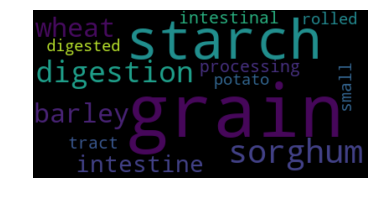

In [216]:

from wordcloud import WordCloud

# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
#d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

# Read the whole text.
text = 'starch grain sorghum digestion barley wheat intestine processing small grains tract intestinal digested potato rolled'

# Generate a word cloud image
wordcloud = WordCloud(collocations=False).generate(text)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# # lower max_font_size
# wordcloud = WordCloud(max_font_size=40).generate(text)
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

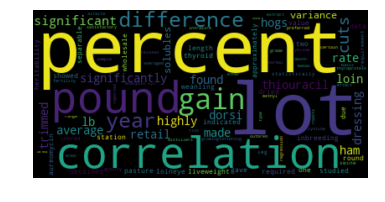

In [15]:
# visualize a topic by putting the top 100 words within a topic in a wordcloud
# size corresponds to rank by weight, but size difference is not proportional to weight difference
from wordcloud import WordCloud
nmf_topic_words100 = [topic[:100] for topic in np.argsort(-abstracts_nmf.components_)]
topic_words = " ".join([abstracts_vocab[idx].strip() for idx in nmf_topic_words100[80]])
wordcloud = WordCloud(collocations=False).generate(topic_words) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

In [228]:
words_per_component = [np.sum(abstracts_nmf.components_[i] > 0) for i in range(len(abstracts_nmf.components_))]

'iVBORw0KGgoAAAANSUhEUgAAAZAAAADICAIAAABJdyC1AADJqUlEQVR4nOx9dZgb19X3GdSImZfZzExJHOY0jA000HBSpjd9y5h+bdqmbbhpmBlsx46dmGFtr9fLvNKKGWY08P2hjVbWSlpJu147ffN79rFHdy7N3Jkz5x4E+Apf4St8hS8JkEm2N1x+tfOVF9JLULGY0OnpwYEC6+cCYdZTM2qZfhuuVyOUKDHs4MPRZAndPaA4Z03wg22ShTOj+1sli2ax3gBhMTDdAzzNSBbODG3aSVaXJUsSI+5JXuPkgZNiSqYPezPvSYVifphxe+ND45uIcUWMDQKASmTy0yMULjNLm3oDe1Ml6XWOaSjHf7nr1DyT+dGyzbEQO+GcRTINHfYCgExXEXYfM3Nj4+qo3x5ydOdpdfJg8UXmc++rE8vx9s+9z3+/hYlz+evrrHM9thZB4POU44SYkunCvsES6owBQTTGJkqms3VtO+b45IDi9DXSFYui+w8H3tuUtYKorkp+6ir3Y88V1WqSwEtrhkmk6jPO4oIBAEAlEuWK1ShFxfv7okePqFatZdwuenAAFVGqU9YjOBbav5cLBFL1CwRCiTh/UNRYheB44O1PFGetinf0J0vo7tH3RxAEqrEaMBQEHpWK+TjD+YMIjgFAqmTCgQiRzNKwDicl9q7PJApj2DsQj3itTac5enaaalfhBBXy9PudHdbG01AUc/XvY+IBa+OpAIijd6fK2EBJdXTUhxFUgg67BvZziXhZ02lD7ZsrZp6FYkTQ1e1ztJvr1sTCrrB3QFc+n5JqSInaM3hQCASUpNEfH1aQBpXIHGJcCIJKcGU44eUFvlIxrze4j+VoBWn00yNxNgwgAACFyZIlCtKYrCPBVc5ot1FS54h2lbCUACDVlouVxrC7HwBRmOqi3mFB4IyNq+2tWzgmJtGWh90DqTooTkp15SFXL6UwJCuzdERpbQq7+gGEZCsMF4lVpqjPhuIkJdf

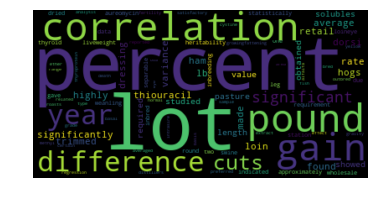

In [20]:
import io
import base64
nmf_topic_words100 = [topic[:100] for topic in np.argsort(-abstracts_nmf.components_)]
topic_words = " ".join([abstracts_vocab[idx].strip() for idx in nmf_topic_words100[80]])
wordcloud = WordCloud(collocations=False).generate(topic_words) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
img = io.BytesIO()
wordcloud.to_image().save(img, 'PNG')
img.seek(0)
lot_url = base64.b64encode(img.getvalue()).decode()
lot_url

NameError: name 'BytesIO' is not defined

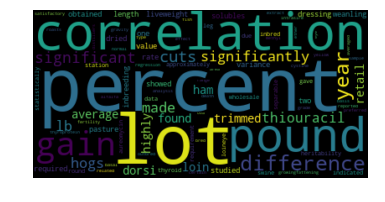

In [14]:
# take a plt generated image and save it as as html

import io
import base64


nmf_topic_words100 = [topic[:100] for topic in np.argsort(-abstracts_nmf.components_)]
topic_words = " ".join([abstracts_vocab[idx].strip() for idx in nmf_topic_words100[80]])
wordcloud = WordCloud(collocations=False).generate(topic_words) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
img = BytesIO()
wordcloud.to_image().save(img, 'PNG')
img.seek(0)
lot_url = base64.b64encode(img.getvalue()).decode()

return '<img src="data:image/png;base64,{}">'.format(plot_url)

